In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from numpy import percentile
from numpy.random import randn
import numpy as np
import os
import math
from scipy.stats import norm, stats

In [12]:
def createStateDf(state, year):
    folder = "data/WICAgencies{}ytd/".format(year)
    
    stateDict = {
        "Date": pd.read_csv("data/WICAgencies{}ytd/Children_Participating.csv".format(year)).columns[1:-1]
    }
    
    for dataFile in os.listdir(folder):
        file = folder + dataFile
        stateDf = pd.read_csv(file).dropna()
        
        
        if len(stateDf.columns) == 14:
            stateData = stateDf[ stateDf[stateDf.columns[0]] == state ]
         
            stateData = np.array(stateDf[ stateDf[stateDf.columns[0]] == state ]).flatten()
            stateData = stateData[1:-1]
            
            stateDict[str(dataFile)[0:-4]] = stateData
        
    return pd.DataFrame(stateDict).drop(["Infants_Fully_Breastfed", "Infants_Fully_Formula-fed", 
                                         "Infants_Partially_Breastfed","Postpartum_Women_Participating", 
                                         "Pregnant_Women_Participating","Rebates_Received", 
                                         "Total_Breastfeeding_Women", "Women_Fully_Breastfeeding",
                                         "Women_Partially_Breastfeeding"], axis=1)


def trunc(df):
    for i, date in enumerate(df["Date"]):
        df.loc[i, "Date"] =  date[:-9]
    return df
        

def createFourYearDf(state):
    years = ["2013", "2014", "2015", "2016"]
    returnDf = pd.DataFrame()
    
    for year in years:
        returnDf = pd.concat([returnDf, trunc(createStateDf(state, year))], axis=0)
    
    return returnDf.reset_index(drop=True)

dfNewYork = createFourYearDf("New York")
dfNewYork.head()

,Date,Total_Infants,Total_Number_of_Participants,Average_Food_Cost_Per_Person,Food_Costs,Children_Participating,Total_Women
0,2012-10-01,117361.0,520563.0,55.5547,28919717.0,278854.0,124348.0
1,2012-11-01,117556.0,515920.0,58.55,30207094.0,275401.0,122963.0
2,2012-12-01,116186.0,506444.0,56.1518,28437767.0,270033.0,120225.0
3,2013-01-01,117897.0,514810.0,57.2702,29483293.0,274112.0,122801.0
4,2013-02-01,117153.0,513555.0,57.7211,29642985.0,274773.0,121629.0


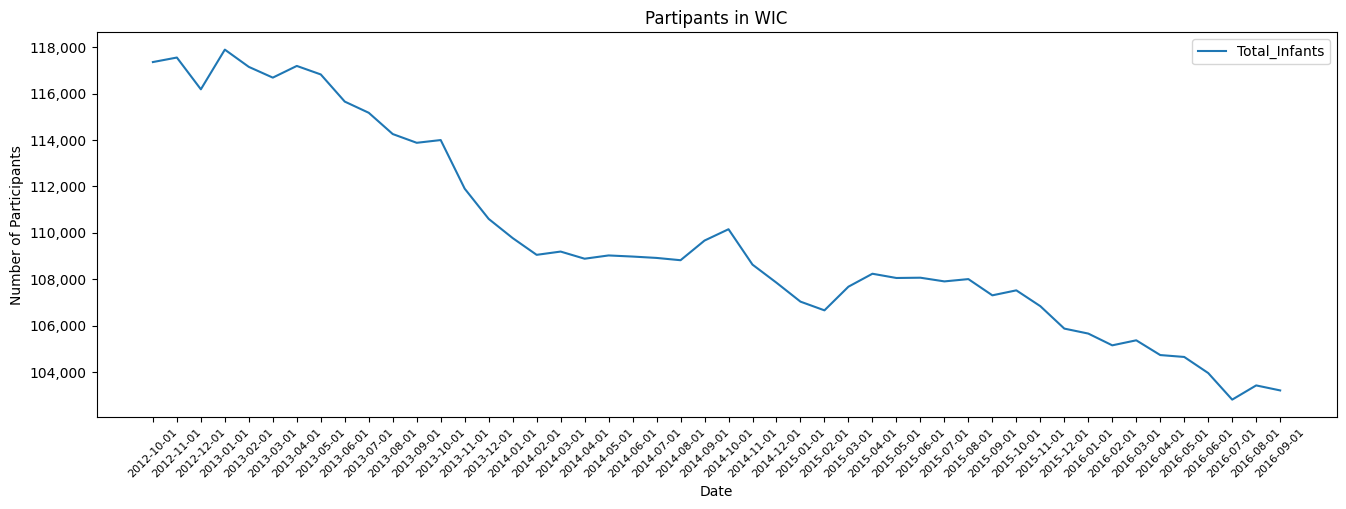

In [21]:
def number_format(x, pos):
    return '{:,.0f}'.format(x)

def graphParticipant(df, participant, name=""):
    plt.figure(figsize=(16, 5))
    plt.plot(df["Date"], df[participant], label=participant)

    plt.title("Partipants in WIC")
    plt.ylabel("Number of Participants") # set a meaningful ylabel
    plt.xlabel("Date") # set the xlabel to "Date"
    plt.xticks(rotation=45, fontsize=8)

    plt.legend()

    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(number_format))
    plt.show()
    
    if name != "":
        fig.savefig('{}--{}.png'.format(name, participant))
        
graphParticipant(dfNewYork, "Total_Infants")

# CREATING AND TRAINING LSTM MODEL

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.layers import ConvLSTM2D
from matplotlib import pyplot as plt

In [138]:
def makeLSTM_TrainAndTest(state, catg, split=0.8):
    df = createFourYearDf("New York")["Total_Number_of_Participants"]
    dataSet = df.values
    dataSet = dataSet.astype("int32")
    
    # Scalarizing Our Inputs for LSTM Model
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    dataSet = scaler.fit_transform(dataSet.reshape(-1, 1))
    
    
    # Training/Testing Dataset
    N_train = int(dataSet.shape[0] * split)
    N_test = dataSet.shape[0] - N_train
    train, test = dataSet[0:N_train,:], dataSet[N_train:len(dataSet),:]

    return train, test, scaler, dataSet
    
train, test, scaler, dataSet = makeLSTM_TrainAndTest("New York", "Total_Number_of_Participants")

In [139]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 5  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


trainX, trainY

Shape of training set: (32, 5)
Shape of test set: (4, 5)


(array([[1.        , 0.93318463, 0.79681969, 0.91721111, 0.89915096],
        [0.93318463, 0.79681969, 0.91721111, 0.89915096, 0.89421499],
        [0.79681969, 0.91721111, 0.89915096, 0.89421499, 0.94566125],
        [0.91721111, 0.89915096, 0.89421499, 0.94566125, 0.95330263],
        [0.89915096, 0.89421499, 0.94566125, 0.95330263, 0.9045762 ],
        [0.89421499, 0.94566125, 0.95330263, 0.9045762 , 0.86316017],
        [0.94566125, 0.95330263, 0.9045762 , 0.86316017, 0.82414736],
        [0.95330263, 0.9045762 , 0.86316017, 0.82414736, 0.79382645],
        [0.9045762 , 0.86316017, 0.82414736, 0.79382645, 0.79620089],
        [0.86316017, 0.82414736, 0.79382645, 0.79620089, 0.63787595],
        [0.82414736, 0.79382645, 0.79620089, 0.63787595, 0.5085336 ],
        [0.79382645, 0.79620089, 0.63787595, 0.5085336 , 0.45687149],
        [0.79620089, 0.63787595, 0.5085336 , 0.45687149, 0.39735214],
        [0.63787595, 0.5085336 , 0.45687149, 0.39735214, 0.42994675],
        [0.5085336 ,

In [140]:
def makeLSTM_Model(trainX, testX, trainY, testY):
    trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
    testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

    # Creating LSTM Aritecture
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    
    # RUNNING MODEL FITTING
    model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=200)
    
    return model

model = makeLSTM_Model(trainX, testX, trainY, testY)

Epoch 1/200
1/1 - 1s - loss: 0.2545 - val_loss: 0.0034 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 0.2432 - val_loss: 0.0028 - 13ms/epoch - 13ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2323 - val_loss: 0.0023 - 13ms/epoch - 13ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2215 - val_loss: 0.0020 - 12ms/epoch - 12ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2109 - val_loss: 0.0017 - 14ms/epoch - 14ms/step
Epoch 6/200
1/1 - 0s - loss: 0.2005 - val_loss: 0.0015 - 13ms/epoch - 13ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1903 - val_loss: 0.0014 - 12ms/epoch - 12ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1804 - val_loss: 0.0014 - 15ms/epoch - 15ms/step
Epoch 9/200
1/1 - 0s - loss: 0.1707 - val_loss: 0.0014 - 13ms/epoch - 13ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1612 - val_loss: 0.0016 - 12ms/epoch - 12ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1519 - val_loss: 0.0018 - 13ms/epoch - 13ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1430 - val_loss: 0.0022 - 13ms/epoch - 13ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1342 - va

Epoch 103/200
1/1 - 0s - loss: 0.0121 - val_loss: 0.0261 - 12ms/epoch - 12ms/step
Epoch 104/200
1/1 - 0s - loss: 0.0120 - val_loss: 0.0259 - 11ms/epoch - 11ms/step
Epoch 105/200
1/1 - 0s - loss: 0.0120 - val_loss: 0.0256 - 12ms/epoch - 12ms/step
Epoch 106/200
1/1 - 0s - loss: 0.0119 - val_loss: 0.0254 - 12ms/epoch - 12ms/step
Epoch 107/200
1/1 - 0s - loss: 0.0119 - val_loss: 0.0252 - 13ms/epoch - 13ms/step
Epoch 108/200
1/1 - 0s - loss: 0.0118 - val_loss: 0.0249 - 12ms/epoch - 12ms/step
Epoch 109/200
1/1 - 0s - loss: 0.0118 - val_loss: 0.0247 - 12ms/epoch - 12ms/step
Epoch 110/200
1/1 - 0s - loss: 0.0117 - val_loss: 0.0245 - 12ms/epoch - 12ms/step
Epoch 111/200
1/1 - 0s - loss: 0.0117 - val_loss: 0.0242 - 13ms/epoch - 13ms/step
Epoch 112/200
1/1 - 0s - loss: 0.0116 - val_loss: 0.0240 - 13ms/epoch - 13ms/step
Epoch 113/200
1/1 - 0s - loss: 0.0116 - val_loss: 0.0237 - 12ms/epoch - 12ms/step
Epoch 114/200
1/1 - 0s - loss: 0.0115 - val_loss: 0.0235 - 12ms/epoch - 12ms/step
Epoch 115/200
1/

1/1 [==============================] - 0s 120ms/step
RMSE Train Score: 6410.42
RMSE Test Score: 7248.09
MAPE Test Score: 0.01
MAPE Test Score: 0.02


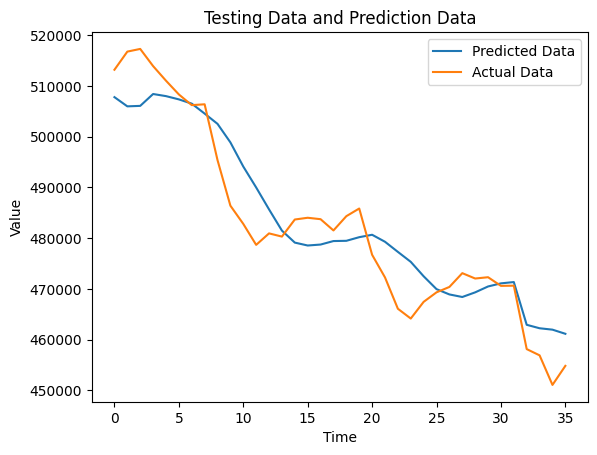

In [141]:
def makeLSTM_AccuracyScore(model, trainX, testX, trainY, testY, dataSet, save=False):
    # Reshaping trainX and testX
    trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
    testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

    # Making Predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    # Reconverting Predictions to Actual Numbers Outside of 0-1 Scale
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    # Generating RMSE and MAPE Scores
    rmseTrain = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    rmseTest = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    mapeTrain = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
    mapeTest = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    
    # Displaying Scores
    print('RMSE Train Score: %.2f' % (rmseTrain))
    print('RMSE Test Score: %.2f' % (rmseTest))
    print('MAPE Test Score: %.2f' % (mapeTrain))
    print('MAPE Test Score: %.2f' % (mapeTest))
    
    # Displaying 
    predictions = np.concatenate((trainPredict.flatten(), testPredict.flatten()))
    actual = np.concatenate((trainY[0], testY[0]))
        
    plt.plot(predictions, label='Predicted Data')
    plt.plot(actual, label='Actual Data')
       
    plt.legend()
    plt.title('Testing Data and Prediction Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()
    
    if save
        
makeLSTM_AccuracyScore(model, trainX, testX, trainY, testY, dataSet, True)

Epoch 1/200
1/1 - 1s - loss: 0.3420 - val_loss: 0.0047 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 0.3296 - val_loss: 0.0040 - 13ms/epoch - 13ms/step
Epoch 3/200
1/1 - 0s - loss: 0.3175 - val_loss: 0.0033 - 14ms/epoch - 14ms/step
Epoch 4/200
1/1 - 0s - loss: 0.3057 - val_loss: 0.0028 - 14ms/epoch - 14ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2942 - val_loss: 0.0023 - 13ms/epoch - 13ms/step
Epoch 6/200
1/1 - 0s - loss: 0.2830 - val_loss: 0.0020 - 13ms/epoch - 13ms/step
Epoch 7/200
1/1 - 0s - loss: 0.2721 - val_loss: 0.0017 - 13ms/epoch - 13ms/step
Epoch 8/200
1/1 - 0s - loss: 0.2615 - val_loss: 0.0015 - 13ms/epoch - 13ms/step
Epoch 9/200
1/1 - 0s - loss: 0.2510 - val_loss: 0.0014 - 12ms/epoch - 12ms/step
Epoch 10/200
1/1 - 0s - loss: 0.2408 - val_loss: 0.0014 - 13ms/epoch - 13ms/step
Epoch 11/200
1/1 - 0s - loss: 0.2307 - val_loss: 0.0015 - 13ms/epoch - 13ms/step
Epoch 12/200
1/1 - 0s - loss: 0.2208 - val_loss: 0.0017 - 12ms/epoch - 12ms/step
Epoch 13/200
1/1 - 0s - loss: 0.2112 - va

Epoch 103/200
1/1 - 0s - loss: 0.0151 - val_loss: 0.0454 - 13ms/epoch - 13ms/step
Epoch 104/200
1/1 - 0s - loss: 0.0150 - val_loss: 0.0452 - 12ms/epoch - 12ms/step
Epoch 105/200
1/1 - 0s - loss: 0.0149 - val_loss: 0.0449 - 12ms/epoch - 12ms/step
Epoch 106/200
1/1 - 0s - loss: 0.0148 - val_loss: 0.0446 - 12ms/epoch - 12ms/step
Epoch 107/200
1/1 - 0s - loss: 0.0147 - val_loss: 0.0444 - 12ms/epoch - 12ms/step
Epoch 108/200
1/1 - 0s - loss: 0.0146 - val_loss: 0.0441 - 13ms/epoch - 13ms/step
Epoch 109/200
1/1 - 0s - loss: 0.0146 - val_loss: 0.0438 - 11ms/epoch - 11ms/step
Epoch 110/200
1/1 - 0s - loss: 0.0145 - val_loss: 0.0435 - 12ms/epoch - 12ms/step
Epoch 111/200
1/1 - 0s - loss: 0.0144 - val_loss: 0.0432 - 12ms/epoch - 12ms/step
Epoch 112/200
1/1 - 0s - loss: 0.0143 - val_loss: 0.0429 - 13ms/epoch - 13ms/step
Epoch 113/200
1/1 - 0s - loss: 0.0142 - val_loss: 0.0425 - 12ms/epoch - 12ms/step
Epoch 114/200
1/1 - 0s - loss: 0.0141 - val_loss: 0.0422 - 12ms/epoch - 12ms/step
Epoch 115/200
1/

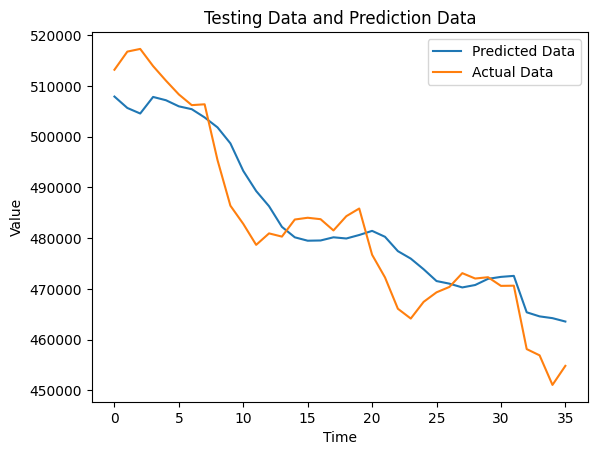

In [149]:
def predictModel(state, catg, seq_size, save=False):
    train, test, scaler, dataSet = makeLSTM_TrainAndTest(state, catg)
    
    trainX, trainY = to_sequences(train, seq_size)
    testX, testY = to_sequences(test, seq_size)

    model = makeLSTM_Model(trainX, testX, trainY, testY)
    makeLSTM_AccuracyScore(model, trainX, testX, trainY, testY, dataSet, True)
    
    
predictModel("Texas", "Total_Number_of_Participants", 5)